─── Cell 1: To-Do ─────────────────────────────────────────────
- Better temporal photobleach correction
- Possible correction for stimulation rate?
- Flagging? i.e. 1Hz cannot have APD90 of >1000ms, etc
- Alternans flagging (duration alternans)
- DAD and EAD flagging
- Fix occasional drifts
- Fix low amplitude peak detection, occasional
- Maybe start_idx (depolarization start) needs better detection settings?

─── Cell 1.5: Changelist ──────────────────────────────────────
- Added "Mean_Values" sheet with mean  
- Added standard deviation for each ROI measurement

In [1]:
# ─── Cell 2: Imports ────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter
import os
import io
import re 

In [ ]:
# ─── Cell 3: Load Excel Workbook & Inspect Sheets ──────────────────────────
np.random.seed(42)  # for reproducibility

# Path to the REAL workbook (template only, not shared in repo)
TEMPLATE_EXCEL = r"C://Users//. . .//Git//Private//Sup_Rep_BeRST_pilot_excel.xlsx"

# Path for SYNTHETIC workbook
SYNTHETIC_EXCEL = "Sup_Rep_BeRST_pilot_excel_SYNTHETIC.xlsx"

# How many time points to generate if needed
N_POINTS = 600
TIME_END = 3.0  # seconds


def make_synthetic_trace(n_points):
    """Single synthetic APD-like trace."""
    t = np.linspace(0, TIME_END, n_points)
    noise = np.random.normal(0, 0.02, n_points)
    signal = 1.2 * np.exp(-((t - 1.2) / 0.05) ** 2) + noise
    return t, signal


def build_synthetic_sheet(xls, sheet_name):
    """
    Read a sheet from the template workbook and build a synthetic
    version with the same columns & layout:
      - Row 0: sample name (string in A1)
      - Row 1+: No., Time, ROI columns (#...) with synthetic values
    """
    # Row 0: sample name row (used only for structure)
    raw = xls.parse(sheet_name, header=None, nrows=1)
    sample_name = str(raw.iloc[0, 0])

    # Row 1+: data with real headers
    df_real = xls.parse(sheet_name, header=1)
    df_real.columns = df_real.columns.astype(str).str.strip()

    # Identify columns
    cols = list(df_real.columns)
    no_col = next((c for c in cols if c.lower().startswith("no")), None)
    time_col = next((c for c in cols if "time" in c.lower()), None)
    roi_cols = [c for c in cols if "#" in c]

    # Decide how many points to generate
    n_points = len(df_real) if len(df_real) > 0 else N_POINTS

    # Build synthetic data
    data = {}
    if no_col is not None:
        data[no_col] = np.arange(1, n_points + 1)
    if time_col is not None:
        t, _ = make_synthetic_trace(n_points)
        data[time_col] = t

    for col in roi_cols:
        _, sig = make_synthetic_trace(n_points)
        data[col] = sig

    df_syn = pd.DataFrame(data)

    # Reorder columns to match original
    df_syn = df_syn[[c for c in cols if c in df_syn.columns]]

    # Compose sheet: top row with sample name, then synthetic data
    top = pd.DataFrame([[sample_name] + [None] * (len(df_syn.columns) - 1)],
                       columns=df_syn.columns)
    sheet_df = pd.concat([top, df_syn], ignore_index=True)
    return sheet_df


# Build synthetic workbook
xls = pd.ExcelFile(TEMPLATE_EXCEL)
with pd.ExcelWriter(SYNTHETIC_EXCEL) as writer:
    for sheet in xls.sheet_names:
        # Skip totally empty / helper sheets if needed
        df_real = xls.parse(sheet, header=1)
        if df_real.dropna(how="all").empty:
            continue

        sheet_df = build_synthetic_sheet(xls, sheet)
        sheet_df.to_excel(writer, sheet_name=sheet, index=False)

print(f"✅ Synthetic demo workbook created: {SYNTHETIC_EXCEL}")

APPLY_FILTERS        = True    # toggle filters
GREY_OUT_UNFILTERED  = True    # grey removed events on plots
band_factor     = 1.5
upstroke_min    = 0.06

C:\Users\Anhnh\AppData\Local\Temp\ipykernel_3848\2631852286.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_df = pd.concat([top, df_syn], ignore_index=True)
C:\Users\Anhnh\AppData\Local\Temp\ipykernel_3848\2631852286.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_df = pd.concat([top, df_syn], ignore_index=True)
C:\Users\Anhnh\AppData\Local\Temp\ipykernel_3848\2631852286.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated

✅ Synthetic demo workbook created: Sup_Rep_BeRST_pilot_excel_SYNTHETIC.xlsx


In [3]:
# ─── Cell 4: Core APD Utility Functions ────────────────────────────────────
def analyze_roi_signal(time, signal, sample_name, roi_label,
                       apply_filters=True,
                       grey_out_unfiltered=True):
    # --- Prep ---\
    signal = pd.to_numeric(signal, errors='coerce').dropna().values
    time   = time[: len(signal)]

    Fmin       = np.min(signal)
    normalized = (signal - Fmin) / Fmin
    smoothed   = gaussian_filter1d(normalized, sigma=1)

    slope_initial = np.gradient(smoothed, time)

    # Photobleaching correction
    flat_thresh = np.percentile(np.abs(slope_initial), 20)
    flat_idxs   = np.where(np.abs(slope_initial) < flat_thresh)[0]
    if flat_idxs.size >= 2:
        bleach_curve = np.interp(time, time[flat_idxs], smoothed[flat_idxs])
        bleach_curve[bleach_curve == 0] = 1
        smoothed = smoothed / bleach_curve

    # Thresholds
    s_max, s_med = np.max(smoothed), np.median(smoothed)
    dr            = s_max - s_med
    rising_thresh = 0.05 * dr
    depol_thresh  = 0.02 * dr

    slope = np.gradient(smoothed, time)

    # Rising-edge groups
    edges  = np.where(slope > rising_thresh)[0]
    groups = []
    for k, g in groupby(enumerate(edges), lambda x: x[0] - x[1]):
        grp = [i for _, i in g]
        if len(grp) >= 5:
            groups.append(grp)

    # Candidate peaks
    peeks = []
    for grp in groups:
        start = grp[0]
        end   = min(grp[-1] + 20, len(smoothed))
        peeks.append(np.argmax(smoothed[start:end]) + start)

    # De-dupe
    filt_peeks = []
    for p in peeks:
        if not filt_peeks or p - filt_peeks[-1] > 40:
            filt_peeks.append(p)

    # Metrics
    rows = []
    for pk in filt_peeks:
        window = range(max(0, pk - 100), pk)
        cand   = [i for i in window if slope[i] < depol_thresh]
        if not cand:
            continue
        start_idx = cand[-1]

        pre       = smoothed[max(0, start_idx - 50): start_idx]
        baseline  = np.min(pre)
        peak_val  = smoothed[pk]
        amp       = peak_val - baseline

        # APD90
        lvl90 = baseline + 0.1 * amp
        repol90_idx = next((i for i in range(pk + 1, len(smoothed)) if smoothed[i] <= lvl90), None)
        if repol90_idx is None:
            continue
        repol90_time  = time[repol90_idx]
        repol90_level = smoothed[repol90_idx]
        apd90         = repol90_time - time[start_idx]

        # APD50
        lvl50 = baseline + 0.5 * amp
        repol50_idx = next((i for i in range(pk + 1, len(smoothed)) if smoothed[i] <= lvl50), None)
        if repol50_idx is None:
            continue
        apd50 = time[repol50_idx] - time[start_idx]

        ratio50_90 = apd50 / apd90 if apd90 > 0 else np.nan
        upstroke   = time[pk] - time[start_idx]

        rows.append({
            'Depolarization_Start_Time_s': time[start_idx],
            'Peak_Time_s'                : time[pk],
            'Amplitude'                  : amp,
            'APD50_s'                    : apd50,
            'APD90_s'                    : apd90,
            'APD50_90_Ratio'             : ratio50_90,
            'Upstroke_Time_s'            : upstroke,
            'Repolarization_Time_s'      : repol90_time,
            'Repolarization_Level'       : repol90_level
        })

    # DataFrame
    df_res_raw = pd.DataFrame(rows).reset_index().rename(columns={'index': '_orig'})
    df_res     = df_res_raw.copy()

    # --- Filters ---
    if apply_filters and not df_res.empty:
        # Upstroke filter
        df_res = df_res[df_res['Upstroke_Time_s'] > upstroke_min]

        # Symmetric APD90 trim
        median_apd90 = df_res['APD90_s'].median()
        lower = median_apd90 / band_factor
        upper = median_apd90 * band_factor
        df_res = df_res[(df_res['APD90_s'] >= lower) & (df_res['APD90_s'] <= upper)]

        df_res = df_res.reset_index(drop=True)

    # Figure out which events were removed (only for plotting, not for summary printing)
    removed = (df_res_raw[~df_res_raw['_orig'].isin(df_res['_orig'])]
               if apply_filters and grey_out_unfiltered else
               pd.DataFrame(columns=df_res_raw.columns))

    expected = [
        'Depolarization_Start_Time_s', 'Peak_Time_s', 'Amplitude',
        'APD50_s', 'APD90_s', 'APD50_90_Ratio', 'Upstroke_Time_s',
        'Repolarization_Time_s', 'Repolarization_Level'
    ]
    df_res = df_res.reindex(columns=['_orig'] + expected)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time, smoothed, label='Signal')

    # Grey-out removed (if desired)
    if grey_out_unfiltered and not removed.empty:
        for i, t in enumerate(removed['Peak_Time_s']):
            ax.axvline(t, color='grey', linestyle='--', alpha=0.3,
                       label='Removed Peak' if i == 0 else None)
        for i, t in enumerate(removed['Depolarization_Start_Time_s']):
            ax.axvline(t, color='grey', linestyle=':', alpha=0.3,
                       label='Removed Depol Start' if i == 0 else None)
        for i, row in enumerate(removed.itertuples()):
            ax.hlines(y=row.Repolarization_Level,
                      xmin=row.Depolarization_Start_Time_s,
                      xmax=row.Repolarization_Time_s,
                      color='grey', linestyle='-', linewidth=2, alpha=0.3,
                      label='Removed APD90' if i == 0 else None)

    # Kept events
    for i, t in enumerate(df_res['Peak_Time_s']):
        ax.axvline(t, color='green', linestyle='--', alpha=0.8,
                   label='Peak' if i == 0 else None)
    for i, t in enumerate(df_res['Depolarization_Start_Time_s']):
        ax.axvline(t, color='black', linestyle='--', alpha=0.5,
                   label='Depol Start' if i == 0 else None)
    for i, row in enumerate(df_res.itertuples()):
        ax.hlines(y=row.Repolarization_Level,
                  xmin=row.Depolarization_Start_Time_s,
                  xmax=row.Repolarization_Time_s,
                  color='red', linestyle='-', linewidth=2, alpha=0.8,
                  label='APD90' if i == 0 else None)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ΔF/Fmin")
    ax.set_title(f"{sample_name} | {roi_label} (bleach-corrected)")
    ax.grid(True)
    fig.tight_layout()

    return sample_name, roi_label, df_res, fig

Displaying plot for: SUPH222P_PostISO002 | #1 (Mono - Tx Red)


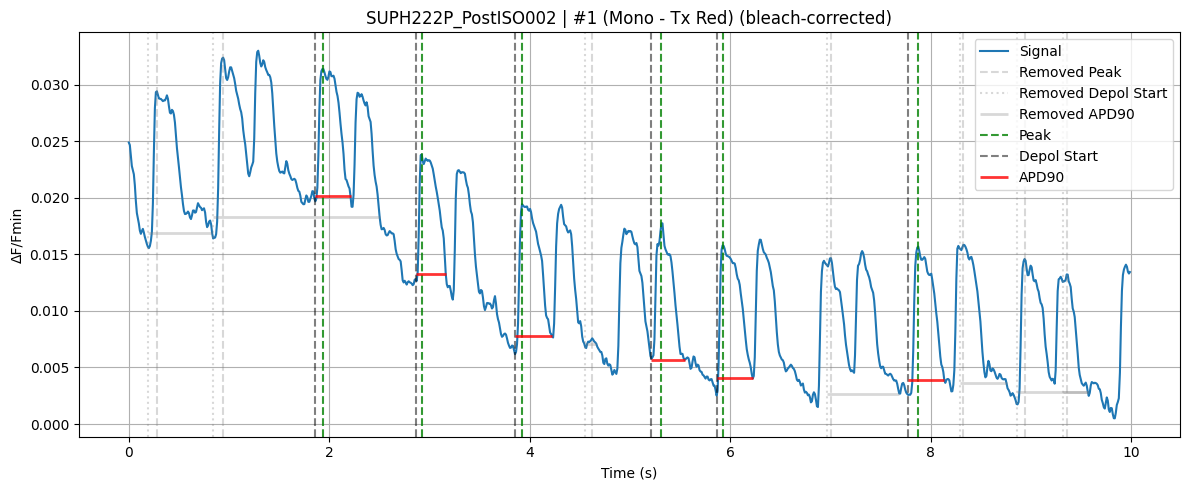

Displaying plot for: SUPH222P_PostISO002 | #2 (Mono - Tx Red)


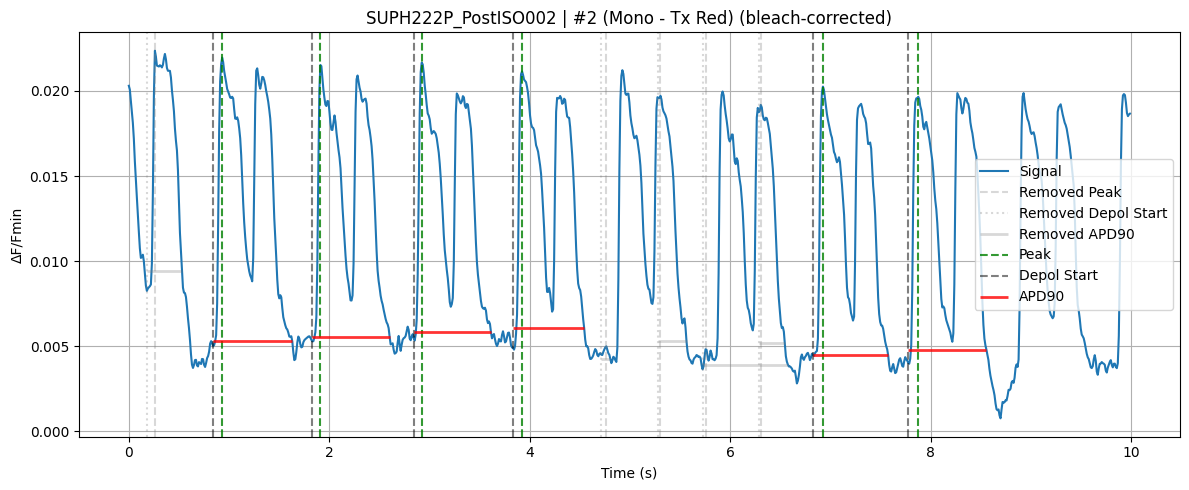

Displaying plot for: SUPH222P_PostISO002 | #3 (Mono - Tx Red)


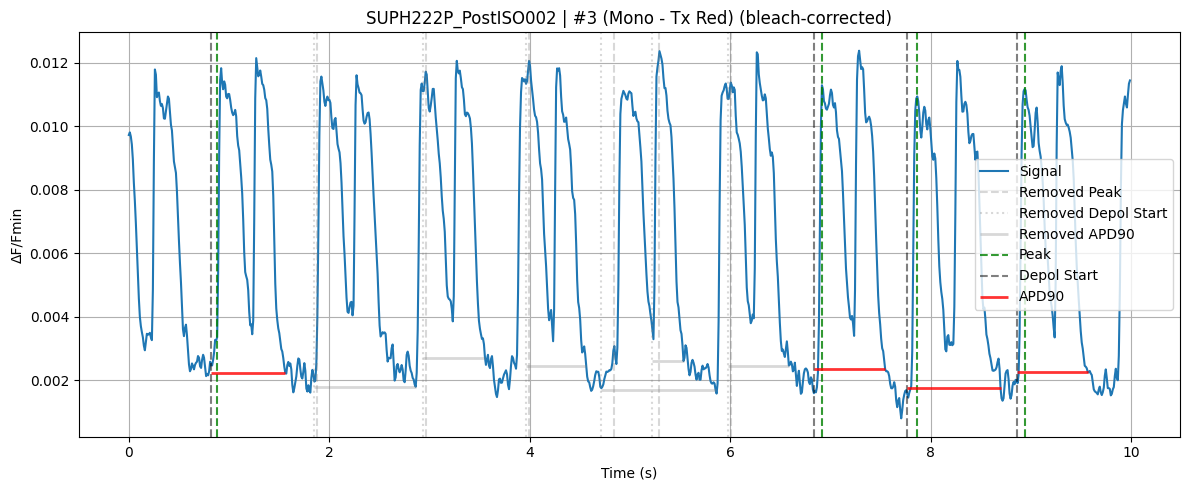

Displaying plot for: SUPH222P_PostISO002 | #4 (Mono - Tx Red)


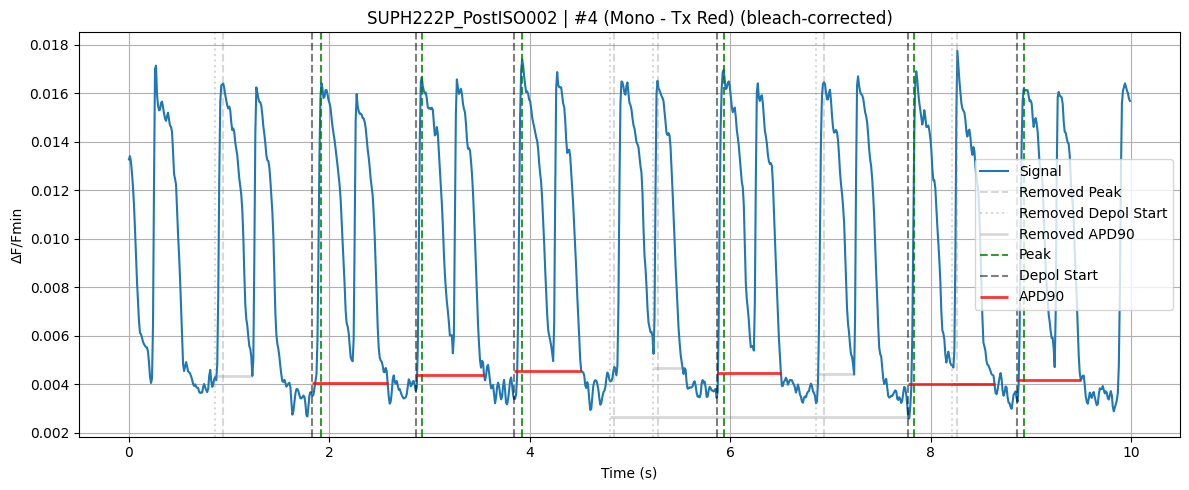

Displaying plot for: SUPH222P_PostISO002 | #5 (Mono - Tx Red)


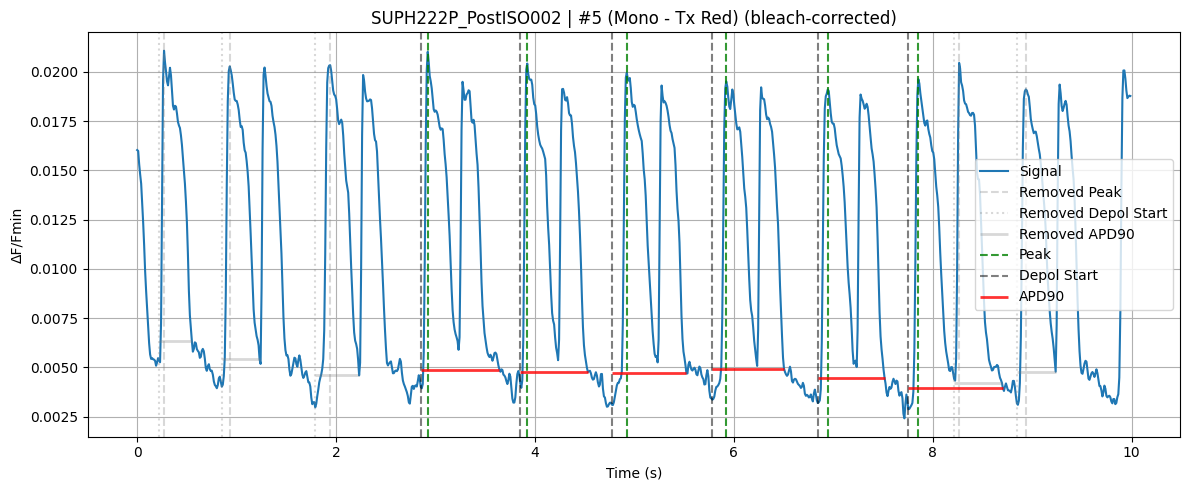

Displaying plot for: SUPH222P_PostISO002 | #6 (Mono - Tx Red)


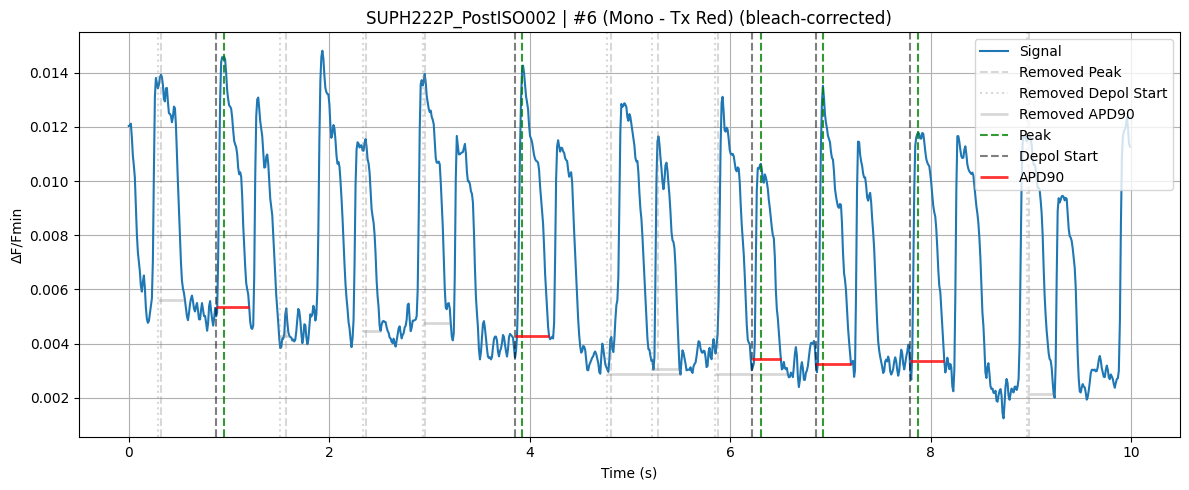

Displaying plot for: SUPH222P_PostISO002 | #7 (Mono - Tx Red)


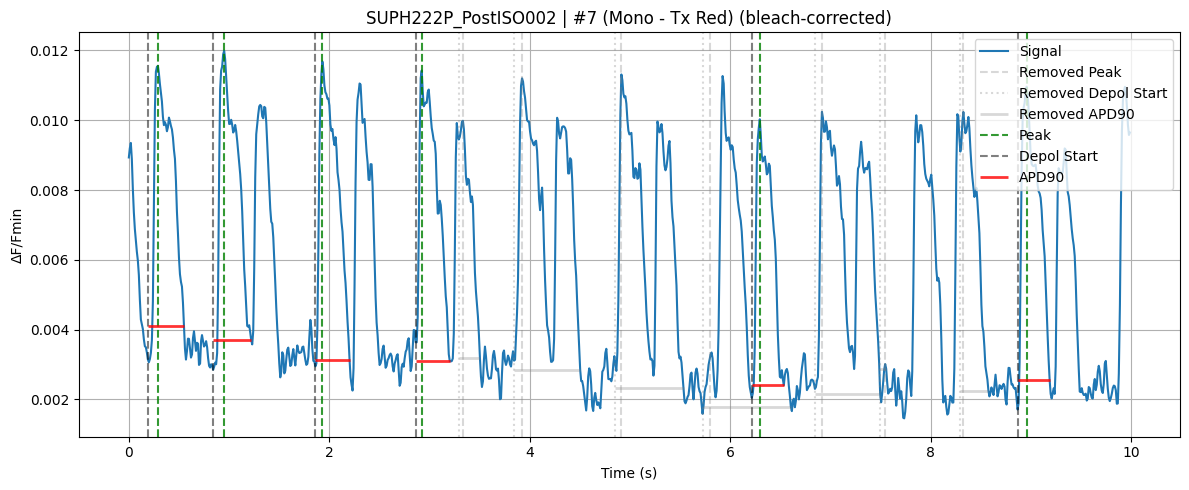

Displaying plot for: SUPH222P_PostISO002 | #8 (Mono - Tx Red)


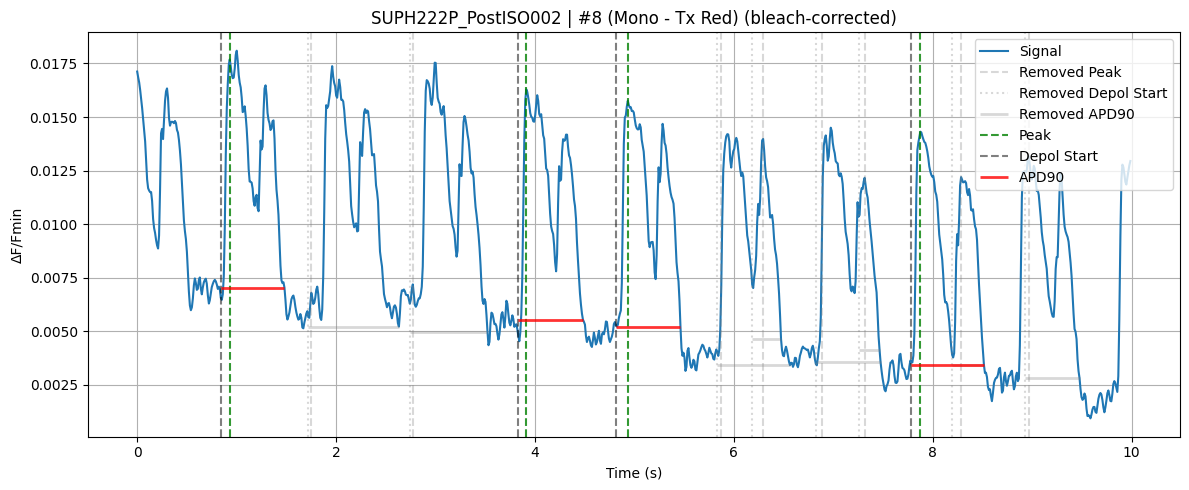

Displaying plot for: SUPH222P_PostISO002 | #9 (Mono - Tx Red)


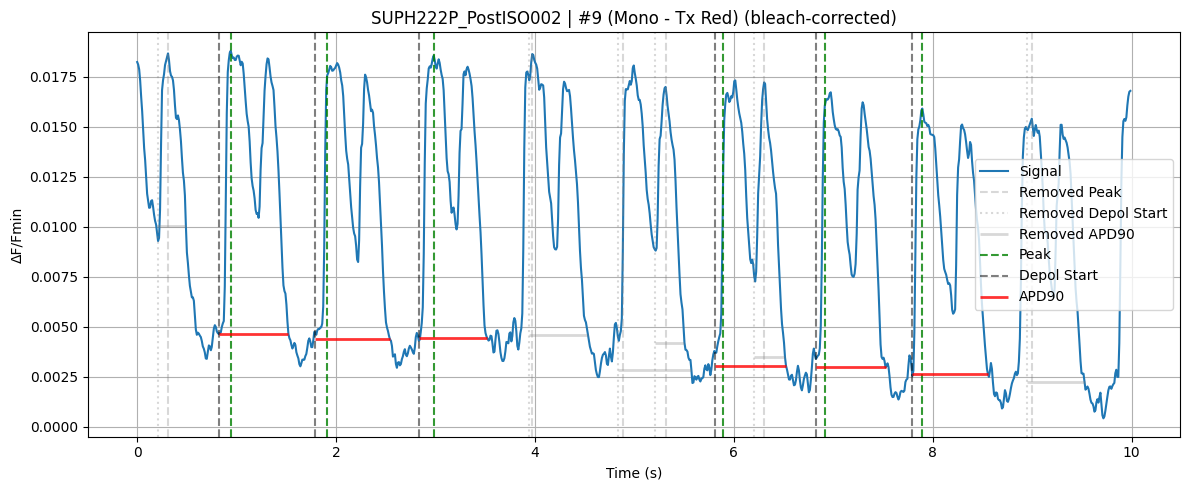

Displaying plot for: SUPH222P_PostISO002 | #10 (Mono - Tx Red)


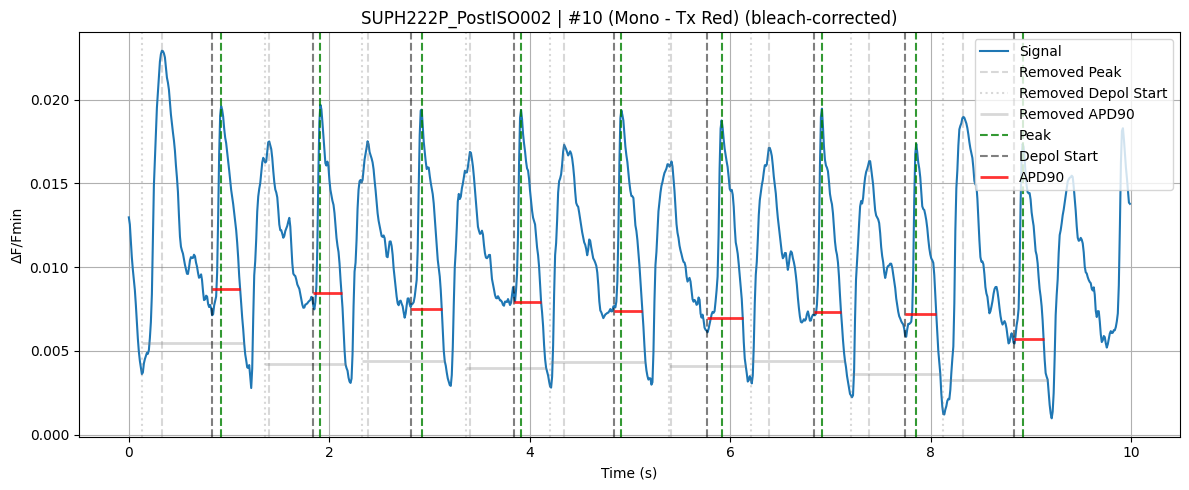

Displaying plot for: CRISPH222P_PreISO011 | #1 (Mono - Tx Red)


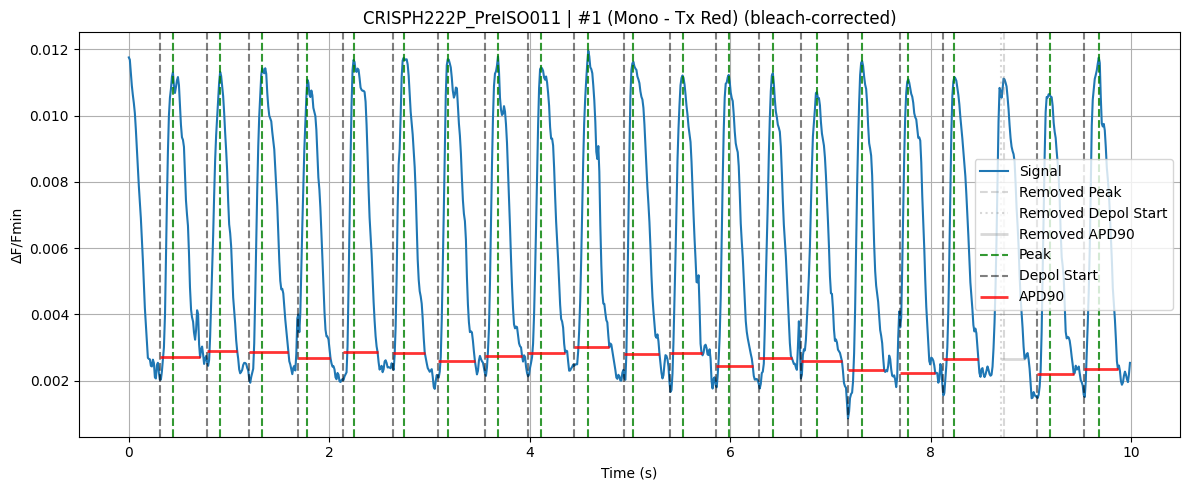

Displaying plot for: CRISPH222P_PreISO011 | #2 (Mono - Tx Red)


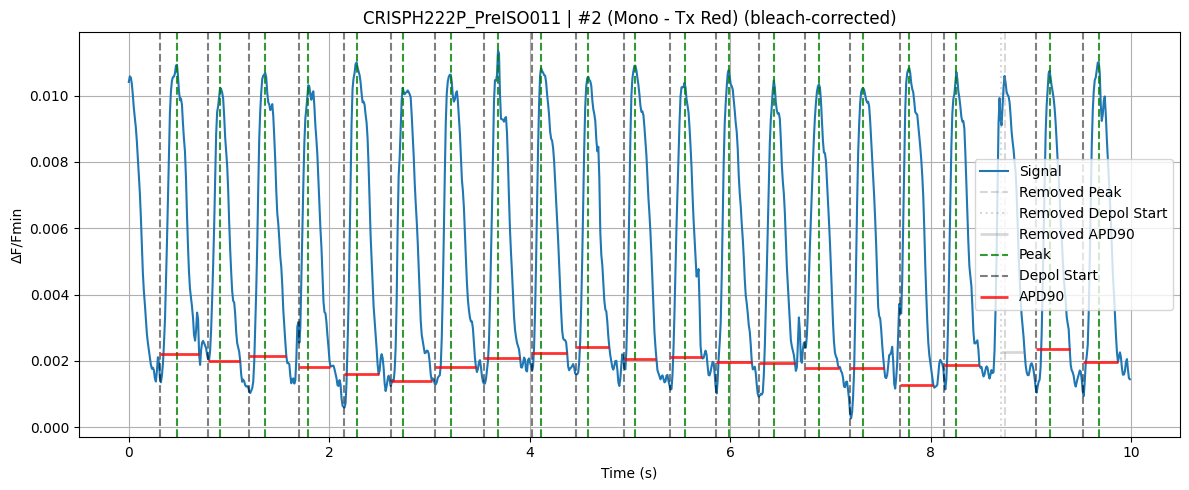

Displaying plot for: CRISPH222P_PreISO011 | #3 (Mono - Tx Red)


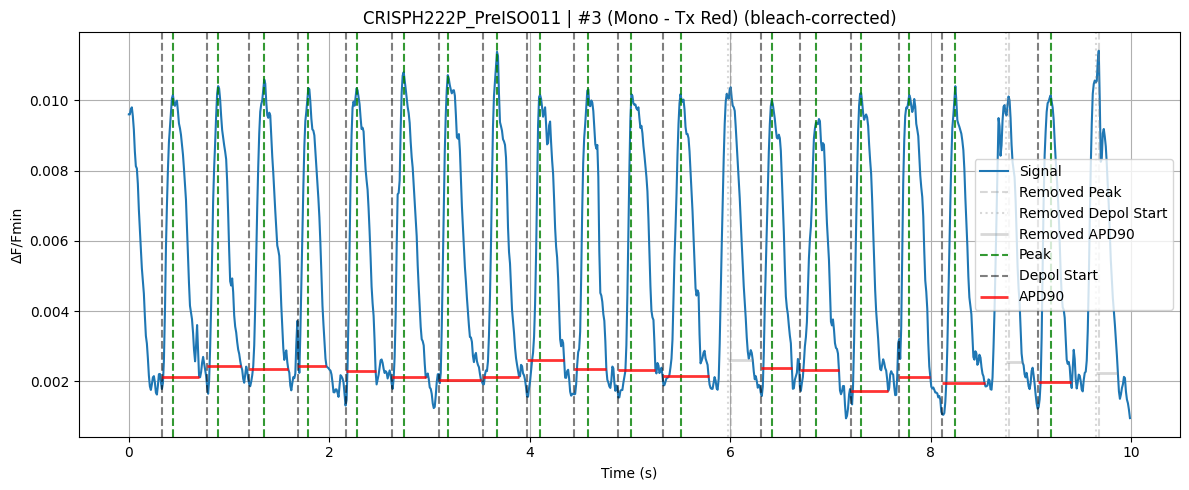

Displaying plot for: CRISPH222P_PreISO011 | #4 (Mono - Tx Red)


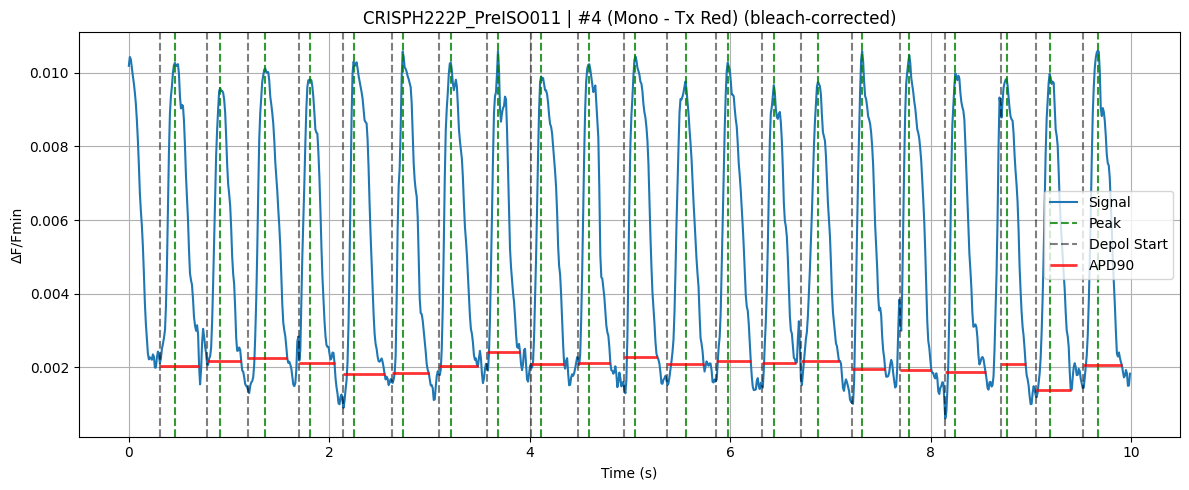

Displaying plot for: CRISPH222P_PreISO011 | #5 (Mono - Tx Red)


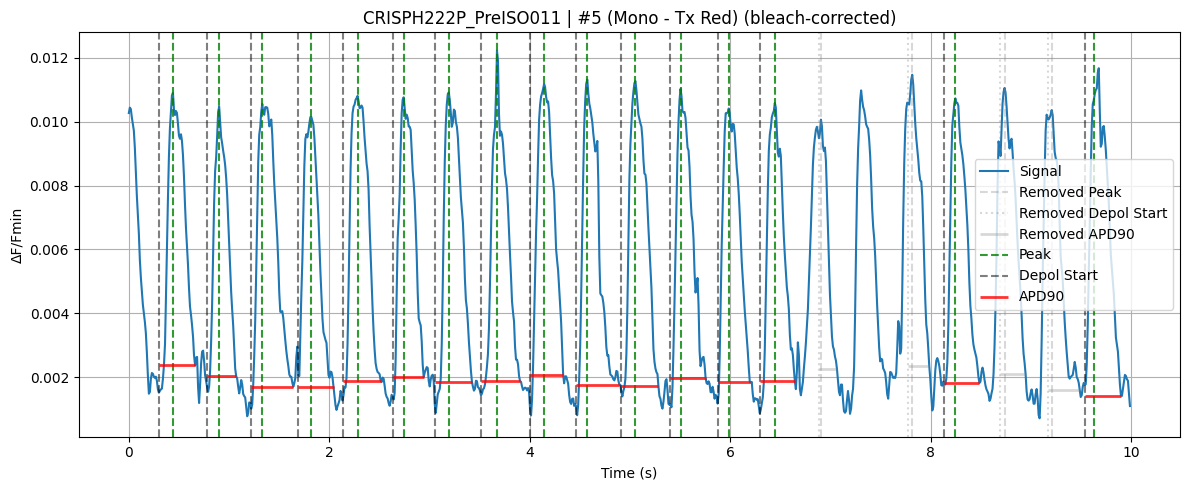

Displaying plot for: CRISPH222P_PreISO011 | #6 (Mono - Tx Red)


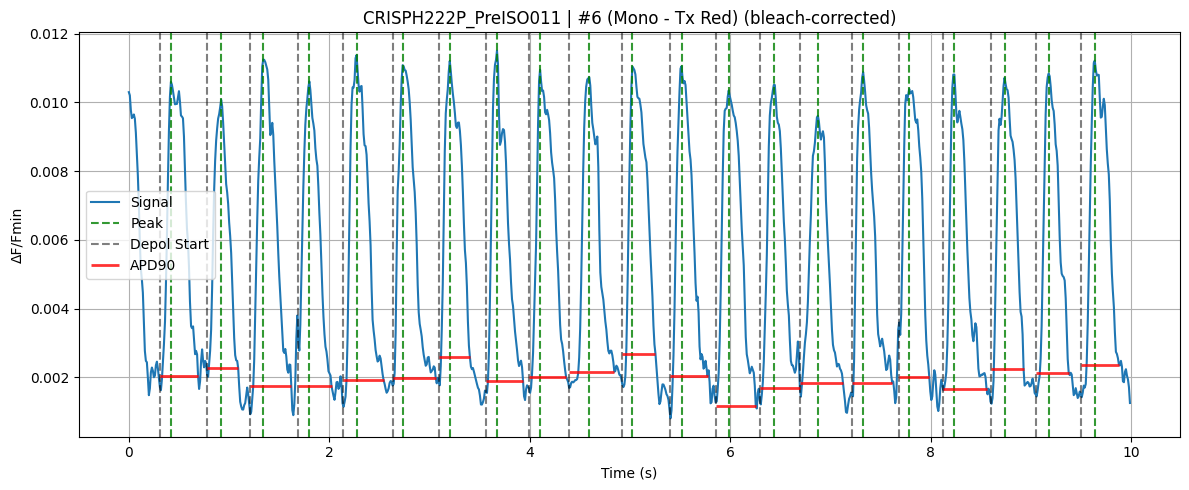

Displaying plot for: CRISPH222P_PreISO011 | #7 (Mono - Tx Red)


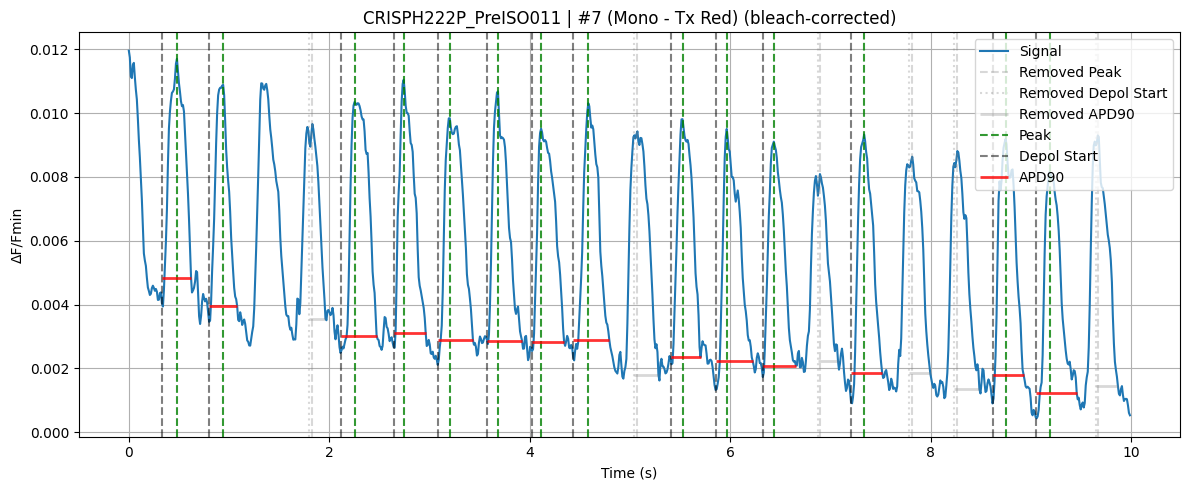

Displaying plot for: CRISPH222P_PreISO011 | #8 (Mono - Tx Red)


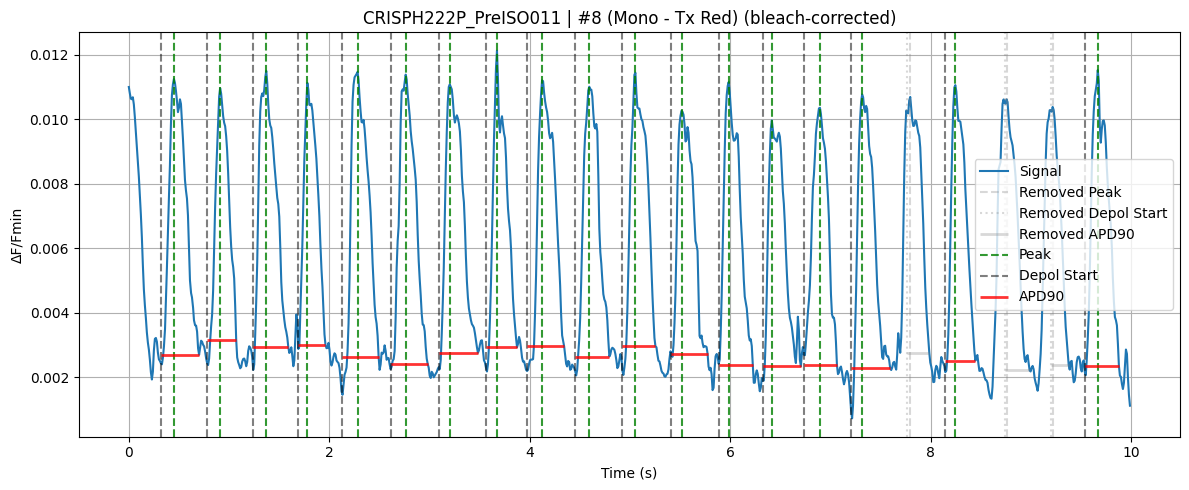

Displaying plot for: CRISPH222P_PreISO011 | #9 (Mono - Tx Red)


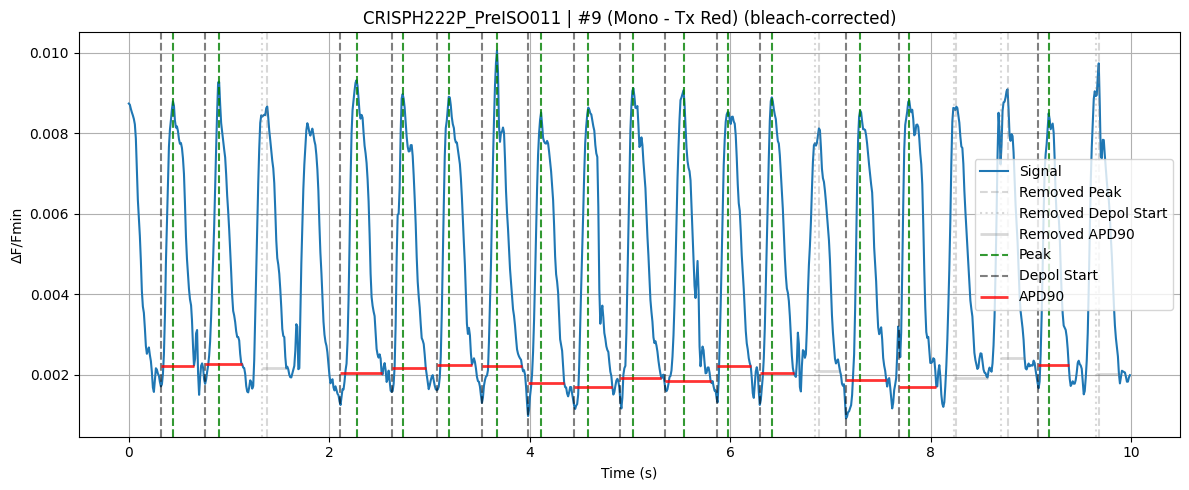

Displaying plot for: CRISPH222P_PreISO011 | #10 (Mono - Tx Red)


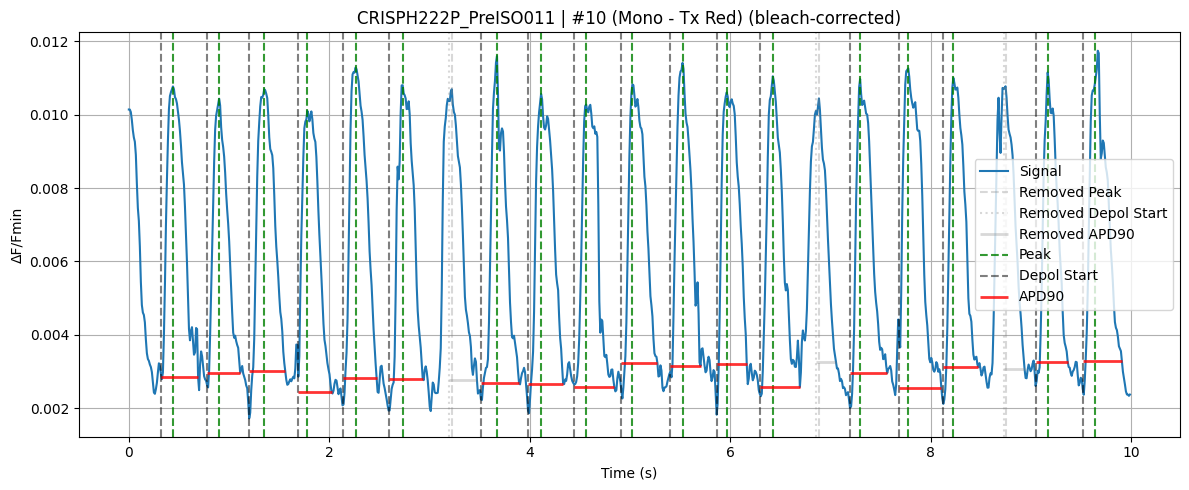

Displaying plot for: CRISPH222P_PreISO010 | #1 (Mono - Tx Red)


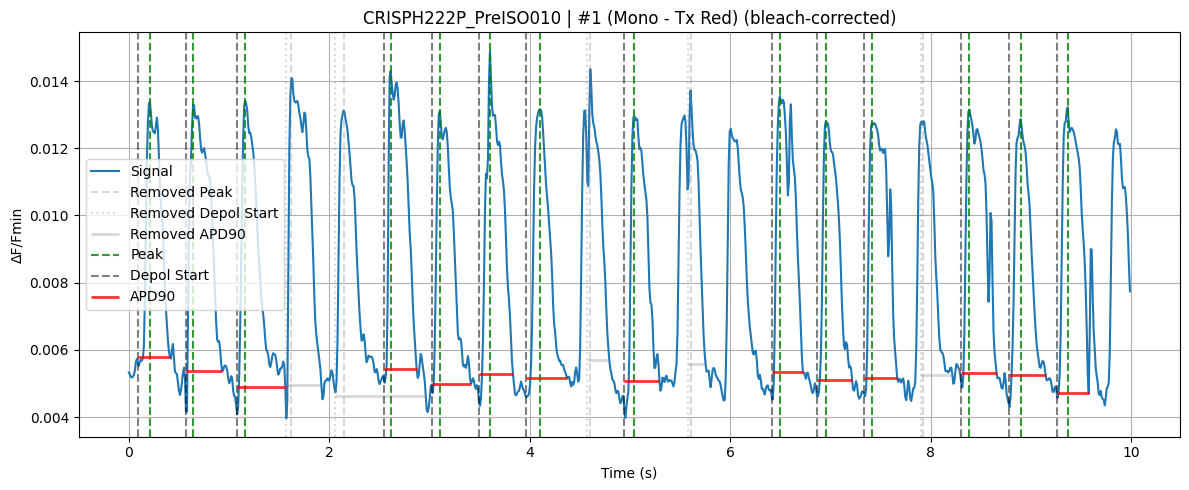

Displaying plot for: CRISPH222P_PreISO010 | #2 (Mono - Tx Red)


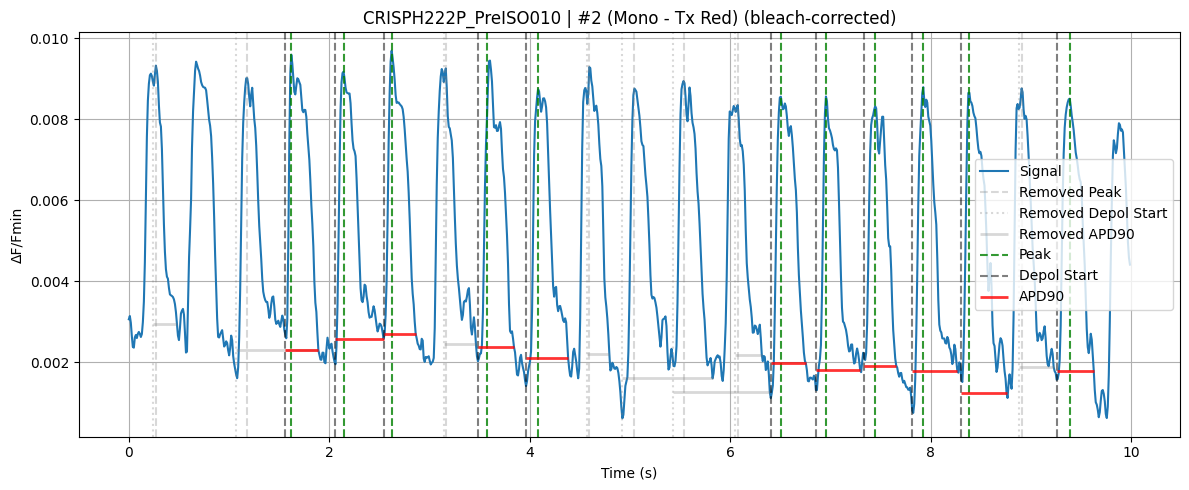

Displaying plot for: CRISPH222P_PreISO010 | #3 (Mono - Tx Red)


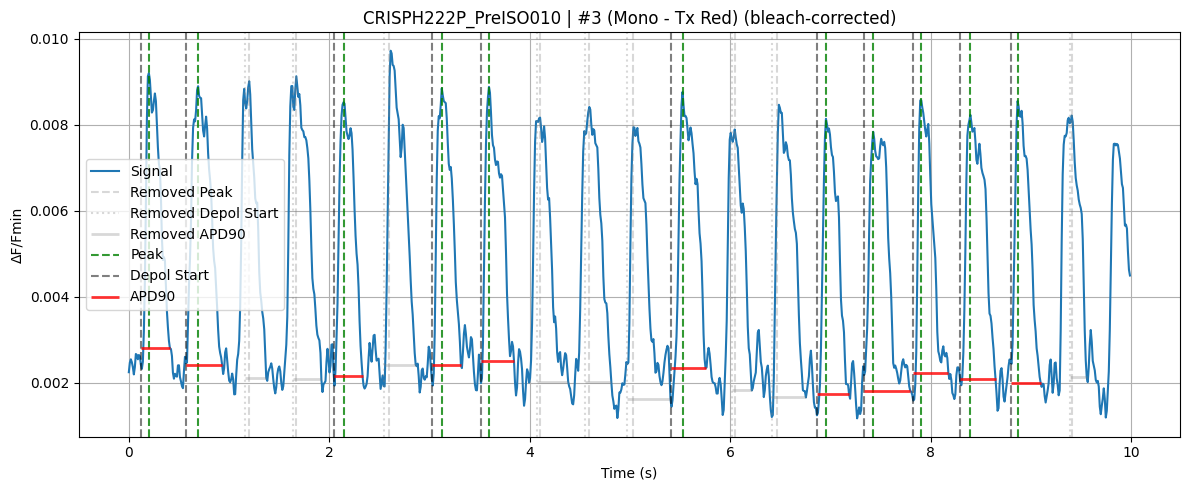

Displaying plot for: CRISPH222P_PreISO010 | #4 (Mono - Tx Red)


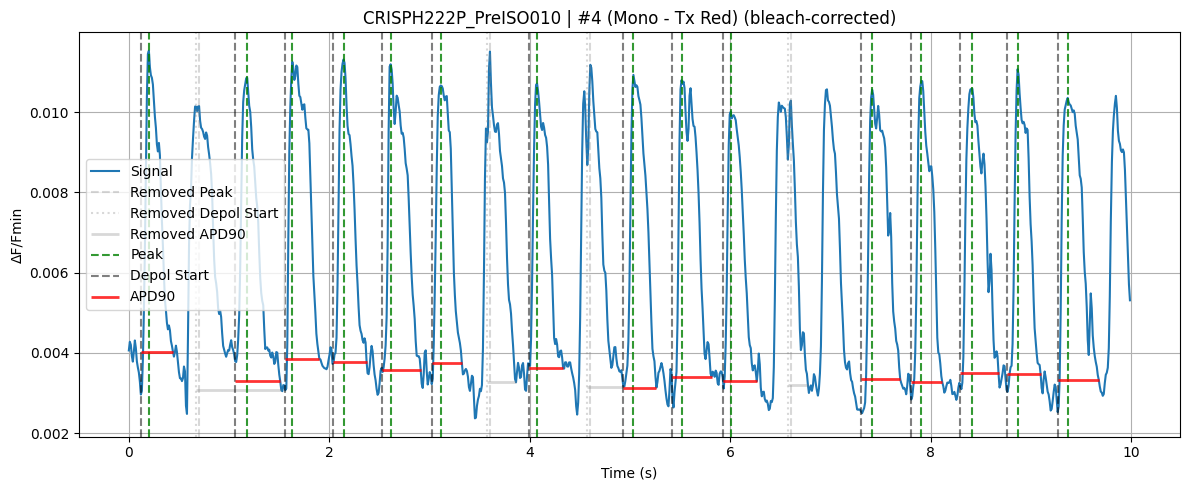

Displaying plot for: CRISPH222P_PreISO010 | #5 (Mono - Tx Red)


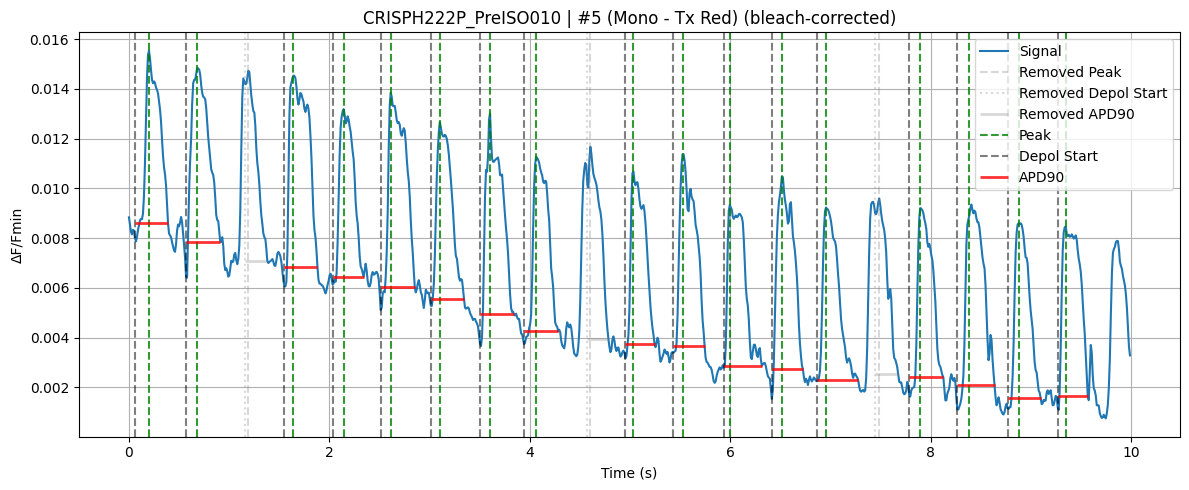

Displaying plot for: CRISPH222P_PreISO010 | #6 (Mono - Tx Red)


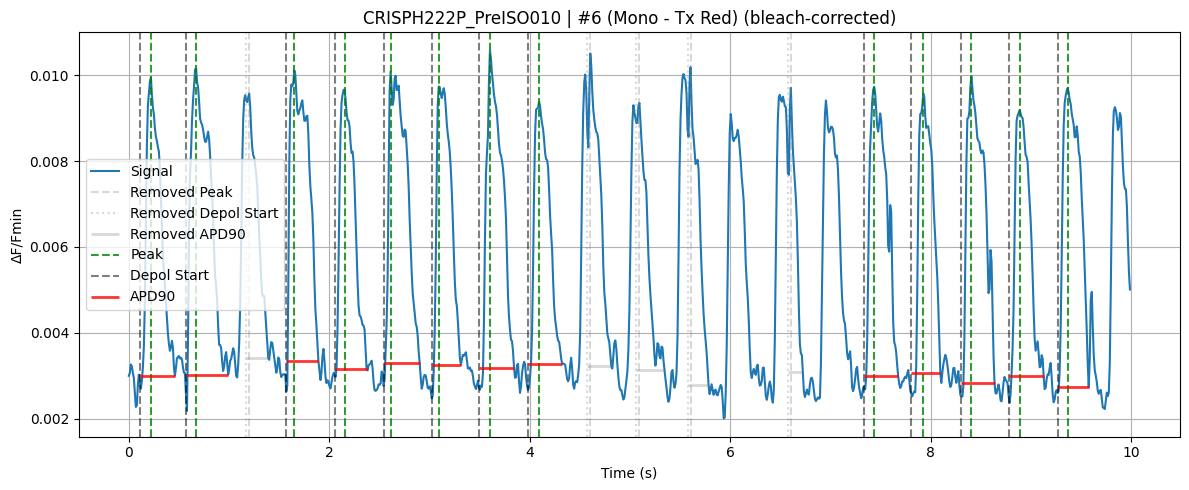

Displaying plot for: CRISPH222P_PreISO010 | #7 (Mono - Tx Red)


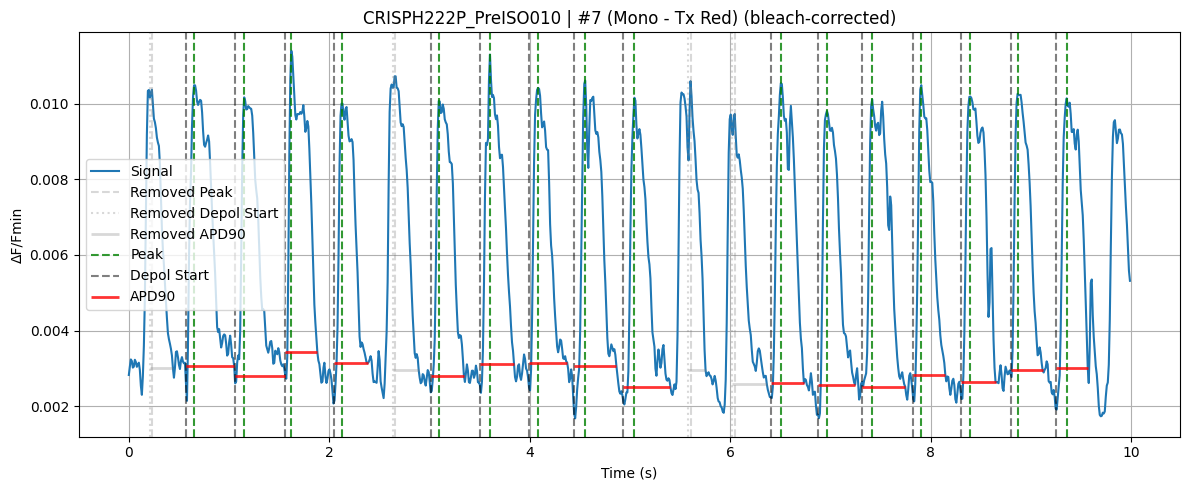

Displaying plot for: CRISPH222P_PreISO010 | #8 (Mono - Tx Red)


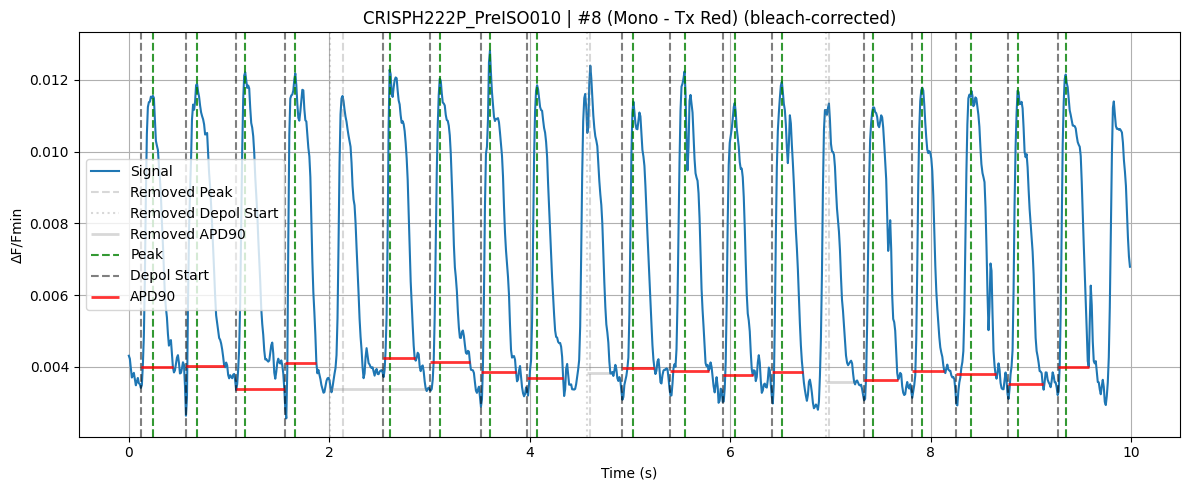

Displaying plot for: CRISPH222P_PreISO010 | #9 (Mono - Tx Red)


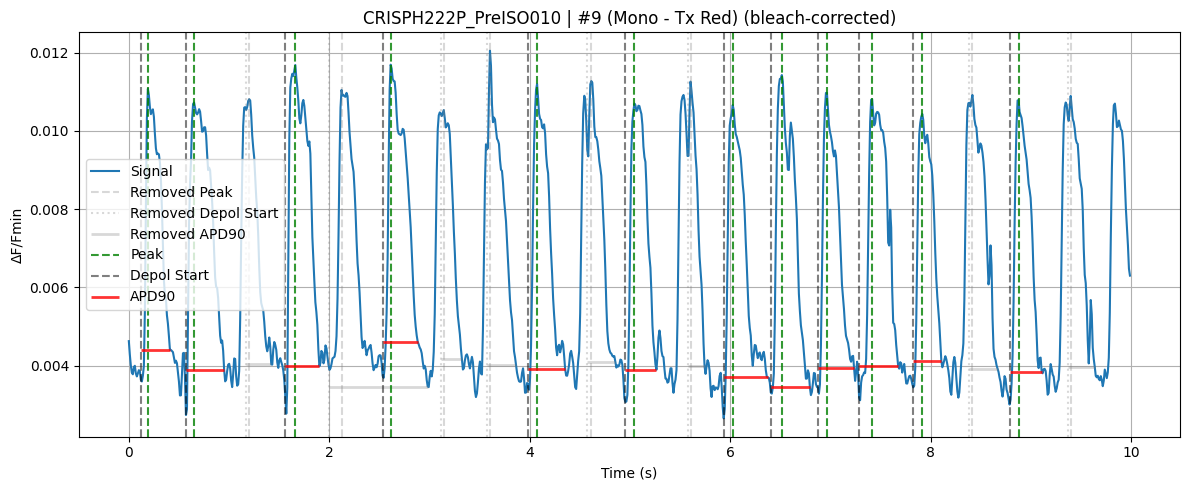

Displaying plot for: CRISPH222P_PreISO010 | #10 (Mono - Tx Red)


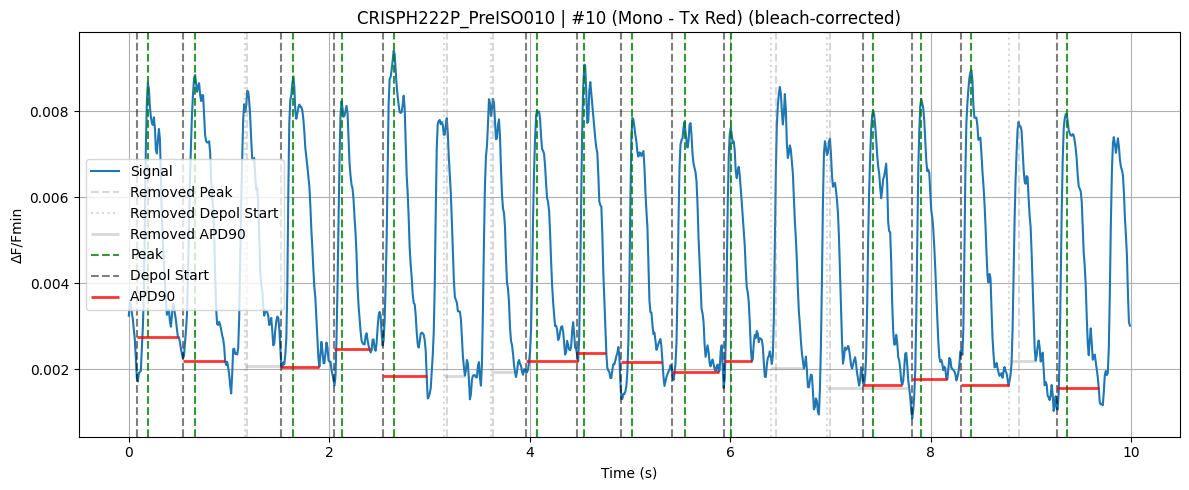

In [4]:
# ─── Cell 5: Main Loop — Call analyze_roi_signal on Each ROI ──────────────
all_results = []
plots       = []

for sheet_name in xls.sheet_names:
    raw = xls.parse(sheet_name, header=None, nrows=1)
    if raw.dropna(how='all').empty:
        continue
    sample_name = str(raw.iloc[0, 0])
    if sample_name.lower().endswith('.nd2'):
        sample_name = sample_name[:-4]

    df = xls.parse(sheet_name, header=1)
    if df.dropna(how='all').empty:
        continue
    df.columns = df.columns.astype(str).str.strip()

    time_cols = [c for c in df.columns if 'time' in c.lower()]
    if not time_cols:
        continue
    time = pd.to_numeric(df[time_cols[0]], errors='coerce').values

    roi_cols = [c for c in df.columns if c != time_cols[0] and '#' in c] #looks for non-time column AND containing #
    for roi in roi_cols:
        samp, roi_label, res_df, fig = analyze_roi_signal(
            time, df[roi], sample_name, roi,
            apply_filters=APPLY_FILTERS,
            grey_out_unfiltered=GREY_OUT_UNFILTERED
        )

        res_df.insert(0, 'Sample', samp)
        res_df.insert(1, 'ROI', roi_label)

        all_results.append(res_df)
        plots.append((samp, roi_label, fig))

        # === FIX: Display the plot immediately after creation ===
        print(f"Displaying plot for: {samp} | {roi_label}")
        display(fig)
        plt.close(fig) # Prevents the figure from being held in memory and displayed again later

In [5]:
# ─── Cell 6: Aggregate & Display Results ───────────────────────────────────
if all_results:
    summary_df = pd.concat(all_results, ignore_index=True)

    # === UPDATED: Sort the summary_df by Sample and numerical ROI ===
    summary_df['ROI_num'] = summary_df['ROI'].str.extract('(\d+)').astype(int)
    summary_df = summary_df.sort_values(by=['Sample', 'ROI_num']).drop(columns=['ROI_num']).reset_index(drop=True)

    print("Filtered summary:")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(summary_df)

    # === Calculate mean and standard deviation values per ROI ===
    mean_summary_df = summary_df.groupby(['Sample', 'ROI'])[[
        'Amplitude',
        'APD50_s',
        'APD90_s',
        'APD50_90_Ratio',
        'Upstroke_Time_s',
        'Repolarization_Time_s'
    ]].agg(['mean', 'std']).reset_index()
    
    # Flatten the column names after aggregation
    mean_summary_df.columns = ['_'.join(col).strip() for col in mean_summary_df.columns.values]
    mean_summary_df = mean_summary_df.rename(columns={'Sample_': 'Sample', 'ROI_': 'ROI'})


    # === UPDATED: Sort the mean_summary_df by Sample and numerical ROI ===
    mean_summary_df['ROI_num'] = mean_summary_df['ROI'].str.extract('(\d+)').astype(int)
    mean_summary_df = mean_summary_df.sort_values(by=['Sample', 'ROI_num']).drop(columns=['ROI_num']).reset_index(drop=True)

print("Filtered summary:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary_df)

print("\nMean values per ROI:")
display(mean_summary_df)

Filtered summary:


Sample                  ROI  _orig  \
0    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      0   
1    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      1   
2    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      2   
3    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      5   
4    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      6   
5    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      7   
6    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      8   
7    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     10   
8    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     12   
9    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     13   
10   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     14   
11   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     16   
12   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     17   
13   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     18   
14   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      2   
15   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      3   
16   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      4   
17   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      6   
18   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      7   
19   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     12   
20   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     13   
21   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     14   
22   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     15   
23   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     16   
24   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     18   
25   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      0   
26   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      1   
27   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      4   
28   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      6   
29   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      7   
30   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     11   
31   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     14   
32   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     15   
33   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     16   
34   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     17   
35   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     18   
36   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      0   
37   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      2   
38   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      3   
39   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      4   
40   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      5   
41   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      6   
42   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      8   
43   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     10   
44   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     11   
45   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     12   
46   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     14   
47   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     15   
48   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     16   
49   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     17   
50   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     18   
51   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      0   
52   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      1   
53   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      3   
54   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      4   
55   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      5   
56   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      6   
57   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      7   
58   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      8   
59   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     10   
60   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     11   
61   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     12   
62   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     13   
63   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     14   
64   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     16   
65   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     17   
66   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     18   
67   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     19   
68   CRISPH222P_PreISO010   #6 (Mono - Tx Red)      0   
69   CRISPH222P_PreISO010   #

Filtered summary:


Sample                  ROI  _orig  \
0    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      0   
1    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      1   
2    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      2   
3    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      5   
4    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      6   
5    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      7   
6    CRISPH222P_PreISO010   #1 (Mono - Tx Red)      8   
7    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     10   
8    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     12   
9    CRISPH222P_PreISO010   #1 (Mono - Tx Red)     13   
10   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     14   
11   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     16   
12   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     17   
13   CRISPH222P_PreISO010   #1 (Mono - Tx Red)     18   
14   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      2   
15   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      3   
16   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      4   
17   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      6   
18   CRISPH222P_PreISO010   #2 (Mono - Tx Red)      7   
19   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     12   
20   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     13   
21   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     14   
22   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     15   
23   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     16   
24   CRISPH222P_PreISO010   #2 (Mono - Tx Red)     18   
25   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      0   
26   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      1   
27   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      4   
28   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      6   
29   CRISPH222P_PreISO010   #3 (Mono - Tx Red)      7   
30   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     11   
31   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     14   
32   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     15   
33   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     16   
34   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     17   
35   CRISPH222P_PreISO010   #3 (Mono - Tx Red)     18   
36   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      0   
37   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      2   
38   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      3   
39   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      4   
40   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      5   
41   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      6   
42   CRISPH222P_PreISO010   #4 (Mono - Tx Red)      8   
43   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     10   
44   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     11   
45   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     12   
46   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     14   
47   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     15   
48   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     16   
49   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     17   
50   CRISPH222P_PreISO010   #4 (Mono - Tx Red)     18   
51   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      0   
52   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      1   
53   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      3   
54   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      4   
55   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      5   
56   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      6   
57   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      7   
58   CRISPH222P_PreISO010   #5 (Mono - Tx Red)      8   
59   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     10   
60   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     11   
61   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     12   
62   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     13   
63   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     14   
64   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     16   
65   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     17   
66   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     18   
67   CRISPH222P_PreISO010   #5 (Mono - Tx Red)     19   
68   CRISPH222P_PreISO010   #6 (Mono - Tx Red)      0   
69   CRISPH222P_PreISO010   #


Mean values per ROI:


Sample                  ROI  Amplitude_mean  Amplitude_std  \
0   CRISPH222P_PreISO010   #1 (Mono - Tx Red)        0.008869       0.000641   
1   CRISPH222P_PreISO010   #2 (Mono - Tx Red)        0.007361       0.000526   
2   CRISPH222P_PreISO010   #3 (Mono - Tx Red)        0.006937       0.000193   
3   CRISPH222P_PreISO010   #4 (Mono - Tx Red)        0.008047       0.000324   
4   CRISPH222P_PreISO010   #5 (Mono - Tx Red)        0.007762       0.000483   
5   CRISPH222P_PreISO010   #6 (Mono - Tx Red)        0.007316       0.000395   
6   CRISPH222P_PreISO010   #7 (Mono - Tx Red)        0.008240       0.000361   
7   CRISPH222P_PreISO010   #8 (Mono - Tx Red)        0.008769       0.000441   
8   CRISPH222P_PreISO010   #9 (Mono - Tx Red)        0.007719       0.000459   
9   CRISPH222P_PreISO010  #10 (Mono - Tx Red)        0.006883       0.000640   
10  CRISPH222P_PreISO011   #1 (Mono - Tx Red)        0.009549       0.000384   
11  CRISPH222P_PreISO011   #2 (Mono - Tx Red)        0.009557       0.000418   
12  CRISPH222P_PreISO011   #3 (Mono - Tx Red)        0.008836       0.000539   
13  CRISPH222P_PreISO011   #4 (Mono - Tx Red)        0.008819       0.000473   
14  CRISPH222P_PreISO011   #5 (Mono - Tx Red)        0.009862       0.000539   
15  CRISPH222P_PreISO011   #6 (Mono - Tx Red)        0.009568       0.000519   
16  CRISPH222P_PreISO011   #7 (Mono - Tx Red)        0.007884       0.000382   
17  CRISPH222P_PreISO011   #8 (Mono - Tx Red)        0.009174       0.000510   
18  CRISPH222P_PreISO011   #9 (Mono - Tx Red)        0.007533       0.000480   
19  CRISPH222P_PreISO011  #10 (Mono - Tx Red)        0.008661       0.000448   
20   SUPH222P_PostISO002   #1 (Mono - Tx Red)        0.012593       0.000696   
21   SUPH222P_PostISO002   #2 (Mono - Tx Red)        0.017095       0.000774   
22   SUPH222P_PostISO002   #3 (Mono - Tx Red)        0.007716       0.004333   
23   SUPH222P_PostISO002   #4 (Mono - Tx Red)        0.013202       0.001062   
24   SUPH222P_PostISO002   #5 (Mono - Tx Red)        0.016866       0.000762   
25   SUPH222P_PostISO002   #6 (Mono - Tx Red)        0.009666       0.001448   
26   SUPH222P_PostISO002   #7 (Mono - Tx Red)        0.008820       0.000389   
27   SUPH222P_PostISO002   #8 (Mono - Tx Red)        0.011822       0.000275   
28   SUPH222P_PostISO002   #9 (Mono - Tx Red)        0.014235       0.001713   
29   SUPH222P_PostISO002  #10 (Mono - Tx Red)        0.012093       0.000518   

    APD50_s_mean  APD50_s_std  APD90_s_mean  APD90_s_std  APD50_90_Ratio_mean  \
0       0.257286     0.017843      0.358143     0.044786             0.730833   
1       0.263727     0.016877      0.391091     0.060917             0.692922   
2       0.247545     0.029149      0.334909     0.049233             0.745343   
3       0.252800     0.028865      0.358133     0.041550             0.709435   
4       0.258412     0.021852      0.336118     0.029610             0.773710   
5       0.251769     0.021568      0.336385     0.033879             0.752641   
6       0.257125     0.029042      0.375938     0.063624             0.696877   
7       0.255471     0.024128      0.349588     0.046193             0.740367   
8       0.253417     0.033195      0.351833     0.046556             0.726676   
9       0.263786     0.027959      0.400214     0.065962             0.672572   
10      0.259750     0.019034      0.354350     0.028972             0.734592   
11      0.261300     0.022725      0.350350     0.028732             0.746503   
12      0.259000     0.027594      0.358056     0.045862             0.728780   
13      0.259286     0.029098      0.353667     0.038409             0.735219   
14      0.259000     0.024749      0.358500     0.036815             0.726731   
15      0.263524     0.023794      0.375095     0.045520             0.710181   
16      0.253071     0.025132      0.332429     0.036502             0.765289   
17      0.259056     0.025445      0.345278     0.035183             0.753247  

In [6]:
# ─── Cell 7: Output ───────────────────────────────────
# === Dynamically build out_path using os.path ===
folder, basename = os.path.split(SYNTHETIC_EXCEL)
name, ext       = os.path.splitext(basename)
new_name        = f"{name}_BatchAnalysis{ext}"
out_path        = os.path.join(folder, new_name)

# === ADDED: Sort the plots list to match the summary sheet order ===
# This will sort the plots first by sample name, then by the numerical ROI number
plots.sort(key=lambda x: (x[0], int(re.search(r'#(\d+)', x[1]).group(1))))


# === Write summary_df, mean_summary_df, and plots into the new workbook ===
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    # 1) summary table
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

    # 2) mean values table
    mean_summary_df.to_excel(writer, sheet_name='Mean_Values', index=False)

    # 3) embed plots
    workbook  = writer.book
    worksheet = workbook.add_worksheet('Plots')

    img_row = 0
    for sample, roi, fig in plots:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)

        worksheet.write(img_row, 0, f"{sample} | {roi}")
        img_row += 1

        worksheet.insert_image(
            img_row, 0,
            f"{sample}_{roi}.png",
            {'image_data': buf, 'x_scale': 0.8, 'y_scale': 0.8}
        )
        img_row += 30

print(f"\n✅ Saved batch analysis to:\n  {out_path}")


✅ Saved batch analysis to:
  Sup_Rep_BeRST_pilot_excel_SYNTHETIC_BatchAnalysis.xlsx
